# Mathematical Underpinnings - Lab 10

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import scale

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import Lasso

## Task 1

In [4]:
df = pd.read_csv('prostate.data', sep="\t", index_col=0)

In [5]:
X = np.array(df.iloc[:, 0:8])
Y = np.array(df.iloc[:, 8])

In [6]:
X = scale(X)
Y = scale(Y)

### a)

In [7]:
mod_lars = Lars(fit_intercept=False)
mod_lars.fit(X, Y)

Lars(fit_intercept=False)

In [8]:
mod_lars.alphas_

array([0.73446033, 0.36963266, 0.3157    , 0.12438766, 0.10869606,
       0.05558212, 0.03210302, 0.01913394, 0.        ])

In [9]:
mod_lars.coef_path_.T

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.36482767,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.39987516,  0.        ,  0.        ,  0.        ,  0.03504749,
         0.        ,  0.        ,  0.        ],
       [ 0.48292339,  0.14883554,  0.        ,  0.        ,  0.15848291,
         0.        ,  0.        ,  0.        ],
       [ 0.48727526,  0.16119869,  0.        ,  0.        ,  0.16571251,
         0.        ,  0.        ,  0.00916856],
       [ 0.50491055,  0.18200727,  0.        ,  0.04431172,  0.19858501,
         0.        ,  0.        ,  0.03388032],
       [ 0.51741672,  0.20157703, -0.05185925,  0.07629111,  0.2110316 ,
         0.        ,  0.        ,  0.05594893],
       [ 0.5223149 ,  0.21336467, -0.08120861,  0.09366845,  0.21890832,
         0.        ,  0.0106656 ,  0.06064448],
       [ 0.57621928,  0.23085294

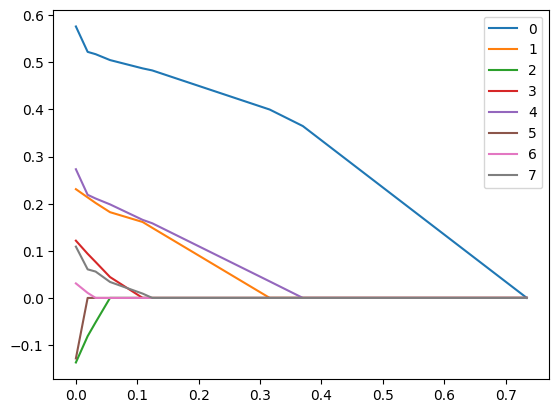

In [10]:
# plot
plt.plot(mod_lars.alphas_, mod_lars.coef_path_.T)
plt.legend(range(8))
plt.show()

In [11]:
np.argsort(np.argmax(mod_lars.coef_path_ != 0, 1))

array([0, 4, 1, 7, 3, 2, 6, 5])

Order in which the variables are included in the model: 0, 4, 1, 7, 3, 2, 6, 5 

### b)

In [12]:
mod_lars.alphas_[0]

0.7344603262136732

In [13]:
corrs = np.corrcoef(X.T, Y)[-1, :-1]
print(corrs)
biggest_corr_arg = np.argmax(corrs)
print(biggest_corr_arg)

[0.73446033 0.43331938 0.16959284 0.1798094  0.56621822 0.54881317
 0.36898681 0.42231586]
0


### b1)

In [14]:
selected_variables = []
selected_variables.append(biggest_corr_arg)

### b2)

In [15]:
mod1 = LinearRegression(fit_intercept=False)
mod1.fit(X[:, selected_variables], Y)
mod1.coef_

array([0.73446033])

### b3)

In [16]:
# code 
corr_tilde_alpha_seq = np.zeros((100, 8))
tilde_alpha_seq = np.linspace(0, 1, 100)

for i in range(100):
    res1 = Y - tilde_alpha_seq[i] * X[:, selected_variables] @ mod1.coef_
    corr_tilde_alpha_seq[i, :] = np.corrcoef(X.T, res1.T)[-1, :8]

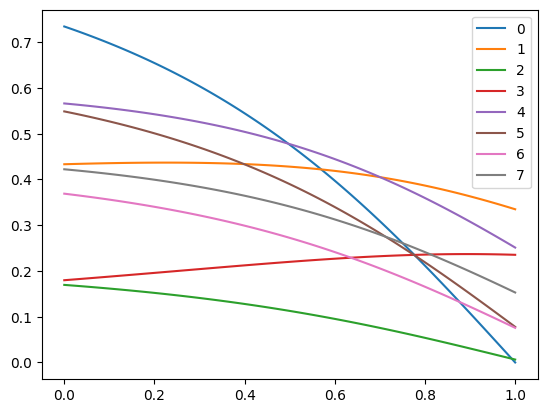

In [17]:
# plot
plt.plot(tilde_alpha_seq, corr_tilde_alpha_seq)
plt.legend(range(8))
plt.show()

0 = blue line

### b4)

4 = purple line

In [18]:
corr_tilde_alpha_seq[49, 0], corr_tilde_alpha_seq[49, 4]

(0.4796152103651895, 0.4788359542571571)

Values are close

### b5)

$$ \textrm{Cor}(Y - \tilde\alpha\hat Y, X_i) = ... \cdot\textrm{Cor}(Y, X_i) - ... \cdot \tilde\alpha \cdot \textrm{Cor}(\tilde\alpha\hat Y, X_i) $$

In our case, $i=0$, $j=4$:
$$ |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_i)| = |\textrm{Cor}(Y - \tilde\alpha\hat Y, X_j)|$$

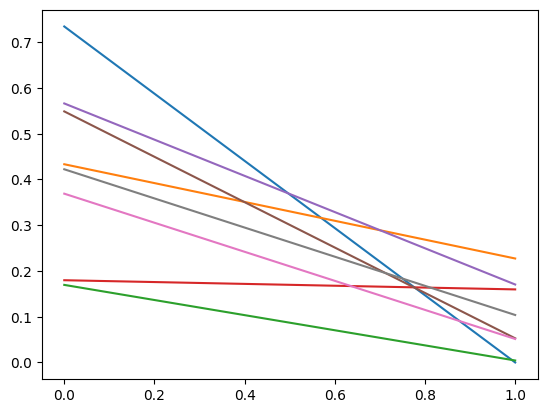

In [19]:
# code
alphas_hat = np.linspace(0, 1, 100)
values = []
for alpha in alphas_hat:
    values_single_alpha = []
    for i in range(len(X[0])):
        a = np.sqrt(np.var(Y)) * np.corrcoef(Y, X[:, i])[0][1]
        y_hat = mod1.predict(X[:, 0].reshape(-1, 1))
        b = np.sqrt(np.var(y_hat)) * np.corrcoef(y_hat, X[:, i])[0][1] * alpha
        values_single_alpha.append(a - b)

    values.append(values_single_alpha)

plt.plot(alphas_hat, values)
plt.show()

In [20]:
first_var_id = 0
second_var_id = 4

Y_hat = X[:, selected_variables] @ mod1.coef_

alpha_2_hat = (np.correlate(X[:, first_var_id].T, Y) - np.correlate(X[:, second_var_id].T, Y)) / (np.correlate(X[:, first_var_id].T, Y_hat) - np.correlate(X[:, second_var_id].T, Y_hat))

In [21]:
alpha_2_hat

array([0.4967289])

### b6)

In [22]:
r2 = Y - alpha_2_hat * mod1.predict(X.T[selected_variables[0]].T.reshape(-1, 1))
np.corrcoef(X.T, r2)[-1, :8][[0, 4]]

array([0.47831254, 0.47831254])

In [23]:
selected_variables.append(4)

In [24]:
alpha_2 = np.sqrt(np.var(Y)) * np.corrcoef(Y, X[:, 4])[0][1] - alpha_2_hat * np.sqrt(np.var(mod1.predict(X[:, 0].reshape(-1,1)))) * np.corrcoef(mod1.predict(X[:, 0].reshape(-1,1)), X[:, 4])[0][1]

In [25]:
alpha_2

array([0.36963266])

### b7)

In [26]:
mod2 = LinearRegression(fit_intercept=False)
mod2.fit(X[:, selected_variables], r2)
mod2.coef_

array([0.24020136, 0.24020136])

### b8)

In [27]:
Y_pred2 = mod2.predict(X[:, selected_variables])

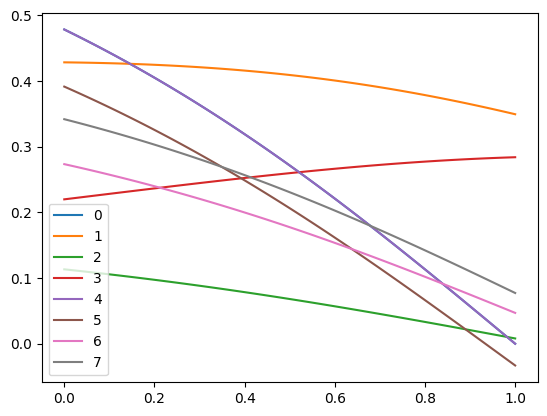

In [28]:
corr_tilde_alpha_seq = np.zeros((100, 8))
tilde_alpha_seq = np.linspace(0, 1, 100)

for i in range(100):
    r2_b8 = r2 - tilde_alpha_seq[i]*Y_pred2
    corr_tilde_alpha_seq[i, :] = np.corrcoef(X.T, r2_b8)[-1, :8]

plt.plot(tilde_alpha_seq, corr_tilde_alpha_seq)
plt.legend(range(8))
plt.show()

purple (and blue)

### b9)

In [29]:
alpha_tilde_3 = 0.14 # approx
selected_variables.append(1) # purple line

### b10)

In [30]:
alpha_tilde_exact_3 =  (np.sqrt(np.var(r2)) * np.corrcoef(r2, X[:,selected_variables[-2]].T)[0,1] - np.sqrt(np.var(r2)) * np.corrcoef(r2,X[:,selected_variables[-1]].T)[0,1]) /  (np.sqrt(np.var(Y_pred2)) * np.corrcoef(Y_pred2, X[:,selected_variables[-2]].T)[0,1] - np.sqrt(np.var(Y_pred2)) * np.corrcoef(Y_pred2, X[:,selected_variables[-1]].T)[0,1])
alpha_tilde_exact_3

0.14590879649354782

### b11)

In [31]:
alpha3 =  np.sqrt(np.var(r2)) * np.corrcoef(r2, X[:, selected_variables[-1]].T)[0,1] - np.sqrt(np.var(Y_pred2)) * alpha_tilde_exact_3 * np.corrcoef(Y_pred2, X[:, selected_variables[-1]].T)[0,1]
alpha3

0.31569999938721716

In [32]:
r3 = r2 - alpha_tilde_exact_3* Y_hat

### c)

## Task 2

In [ ]:
X = pd.read_table("data/SRBCT_X.txt", sep=" ")
Y = pd.read_table("data/SRBCT_Y.txt", sep=" ")

X = np.array(X)
Y = np.array(Y)[:,0]

In [ ]:
X = scale(X)
Y = Y - np.mean(Y)

### a)

In [ ]:
mod_lars = Lars(n_nonzero_coefs=80)
# fit

In [ ]:
# plot

In [ ]:
# the order

### b)

In [ ]:
mod_lassolars = LassoLars(alpha=0.15)
# fit

In [ ]:
# order

In [ ]:
# plot

### c)

In [ ]:
lasso_coef = np.zeros((X.shape[1], mod_lassolars.alphas_.shape[0]))

In [ ]:
for i in range(mod_lassolars.alphas_.shape[0]):
    mod_lasso = Lasso(alpha=mod_lassolars.alphas_[i])
    mod_lasso.fit(X, Y)

    lasso_coef[:,i] = mod_lasso.coef_

In [ ]:
# plot